<a href="https://colab.research.google.com/github/Alexnder77/DeepLearning--methods-and-applications/blob/main/Lab3_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboration: Tidssekvenser och återkopplade neuronnät

## Setup + data cleanup mm.

använder setup + data och Feature engineering från https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/structured_data/time_series.ipynb

In [ ]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

### The weather dataset

This tutorial uses a <a href="https://www.bgc-jena.mpg.de/wetter/" class="external">weather time series dataset</a> recorded by the <a href="https://www.bgc-jena.mpg.de" class="external">Max Planck Institute for Biogeochemistry</a>.

This dataset contains 14 different features such as air temperature, atmospheric pressure, and humidity. These were collected every 10 minutes, beginning in 2003. For efficiency, you will use only the data collected between 2009 and 2016. This section of the dataset was prepared by François Chollet for his book <a href="https://www.manning.com/books/deep-learning-with-python" class="external">Deep Learning with Python</a>.

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13568290/13568290 [==============================] - 1s 0us/step


This tutorial will just deal with **hourly predictions**, so start by sub-sampling the data from 10-minute intervals to one-hour intervals:

In [ ]:
df = pd.read_csv(csv_path)
# Slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

Let's take a glance at the data. Here are the first few rows:

In [ ]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Here is the evolution of a few features over time:

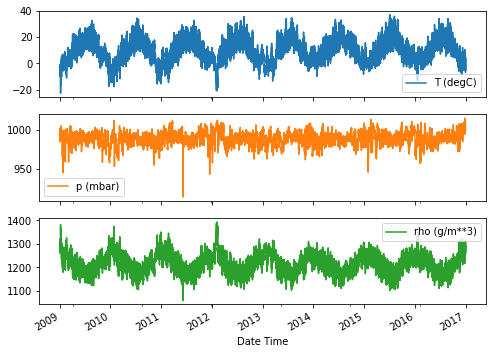

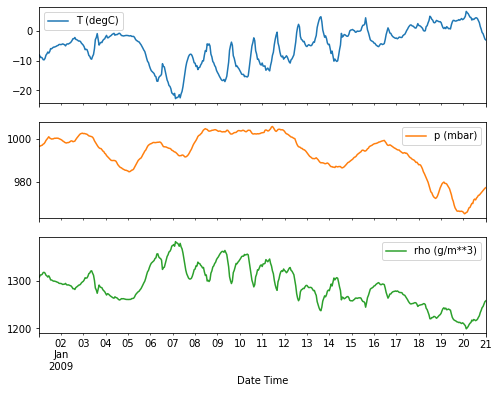

In [ ]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

#### Inspect and cleanup

Next, look at the statistics of the dataset:

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


#### Wind velocity

One thing that should stand out is the `min` value of the wind velocity (`wv (m/s)`) and the maximum value (`max. wv (m/s)`) columns. This `-9999` is likely erroneous.

There's a separate wind direction column, so the velocity should be greater than zero (`>=0`). Replace it with zeros:

In [ ]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame.
df['wv (m/s)'].min()

0.0

### Feature engineering

Before diving in to build a model, it's important to understand your data and be sure that you're passing the model appropriately formatted data.

#### Wind
The last column of the data, `wd (deg)`—gives the wind direction in units of degrees. Angles do not make good model inputs: 360° and 0° should be close to each other and wrap around smoothly. Direction shouldn't matter if the wind is not blowing.

Right now the distribution of wind data looks like this:

Text(0, 0.5, 'Wind Velocity [m/s]')

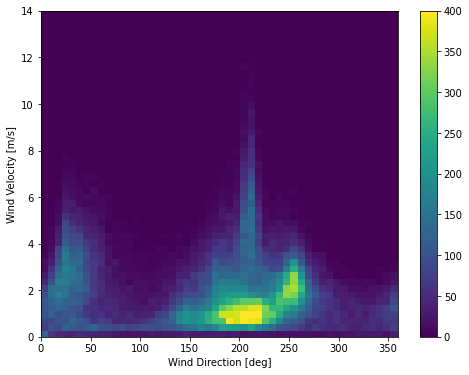

In [ ]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

But this will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind **vector**:

In [ ]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

The distribution of wind vectors is much simpler for the model to correctly interpret:

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

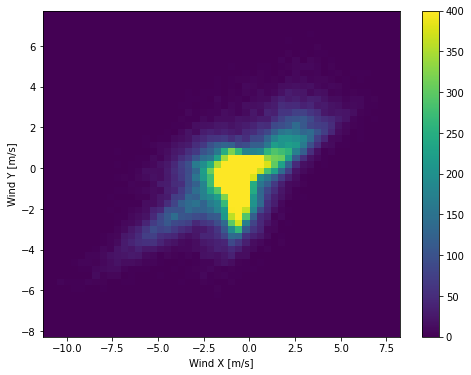

In [ ]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

#### Time

Similarly, the `Date Time` column is very useful, but not in this string form. Start by converting it to seconds:

In [ ]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)

Similar to the wind direction, the time in seconds is not a useful model input. Being weather data, it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

You can get usable signals by using sine and cosine transforms to clear "Time of day" and "Time of year" signals:

In [ ]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

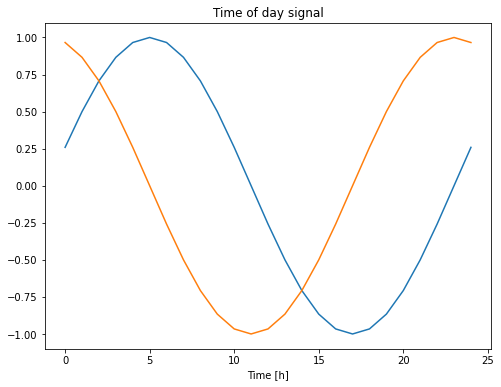

In [ ]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

This gives the model access to the most important frequency features. In this case you knew ahead of time which frequencies were important. 

If you don't have that information, you can determine which frequencies are important by extracting features with <a href="https://en.wikipedia.org/wiki/Fast_Fourier_transform" class="external">Fast Fourier Transform</a>. To check the assumptions, here is the `tf.signal.rfft` of the temperature over time. Note the obvious peaks at frequencies near `1/year` and `1/day`:


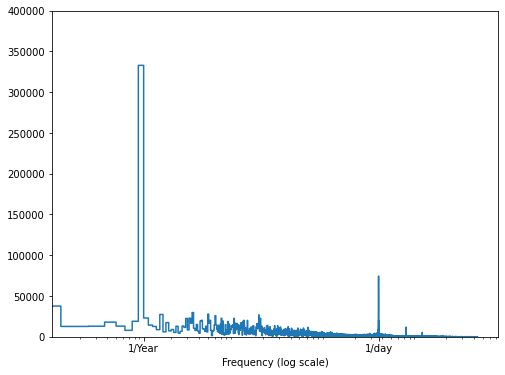

In [ ]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

#### Split the data

You'll use a `(70%, 20%, 10%)` split for the training, validation, and test sets. Note the data is **not** being randomly shuffled before splitting. This is for two reasons:

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

#### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling: subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

It's also arguable that the model shouldn't have access to future values in the training set when training, and that this normalization should be done using moving averages. That's not the focus of this tutorial, and the validation and test sets ensure that you get (somewhat) honest metrics. So, in the interest of simplicity this tutorial uses a simple average.

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

Now, peek at the distribution of the features. Some features do have long tails, but there are no obvious errors like the `-9999` wind velocity value.

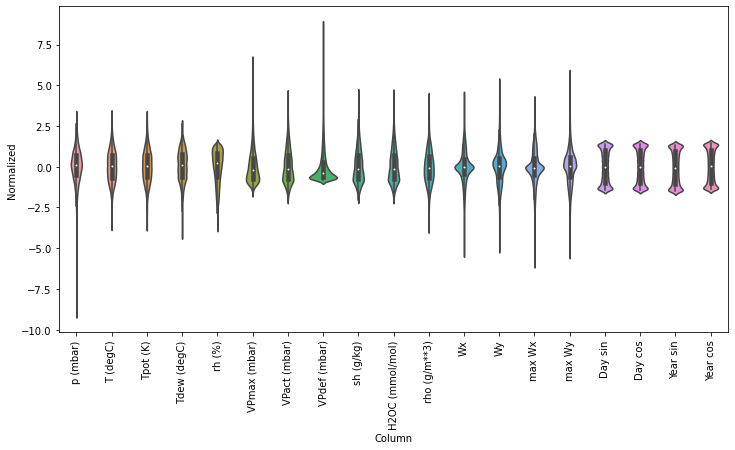

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

###Data windowing

#### 1. Indexes and offsets

Start by creating the `WindowGenerator` class. The `__init__` method includes all the necessary logic for the input and label indices.

It also takes the training, evaluation, and test DataFrames as input. These will be converted to `tf.data.Dataset`s of windows later.

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

Here is code to create the 2 windows shown in the diagrams at the start of this section:

In [ ]:
w1 = WindowGenerator(input_width=25, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w1



Total window size: 26
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Label indices: [25]
Label column name(s): ['T (degC)']

#### 2. Split

Given a list of consecutive inputs, the `split_window` method will convert them to a window of inputs and a window of labels.

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

Try it out:

In [ ]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 26, 19)
Inputs shape: (3, 25, 19)
Labels shape: (3, 1, 1)


Typically, data in TensorFlow is packed into arrays where the outermost index is across examples (the "batch" dimension). The middle indices are the "time" or "space" (width, height) dimension(s). The innermost indices are the features.

The code above took a batch of three 7-time step windows with 19 features at each time step. It splits them into a batch of 6-time step 19-feature inputs, and a 1-time step 1-feature label. The label only has one feature because the `WindowGenerator` was initialized with `label_columns=['T (degC)']`. Initially, this tutorial will build models that predict single output labels.

#### 3. Plot

Here is a plot method that allows a simple visualization of the split window:

In [ ]:
w1.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      
      
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to:

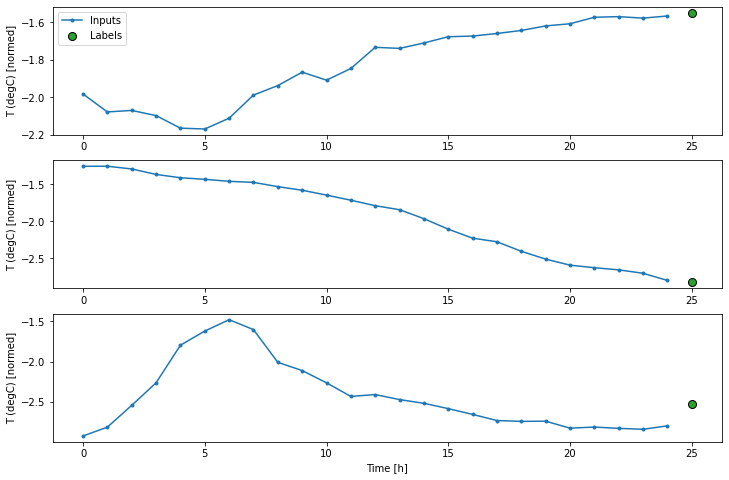

In [ ]:
w1.plot()

You can plot the other columns, but the example window `w2` configuration only has labels for the `T (degC)` column.

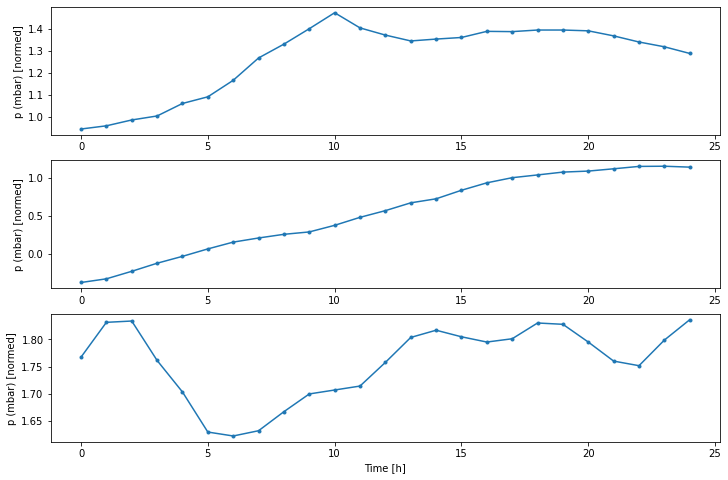

In [ ]:
w1.plot(plot_col='p (mbar)')

#### 4. Create `tf.data.Dataset`s

Finally, this `make_dataset` method will take a time series DataFrame and convert it to a `tf.data.Dataset` of `(input_window, label_window)` pairs using the `tf.keras.utils.timeseries_dataset_from_array` function:

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The `WindowGenerator` object holds training, validation, and test data.

Add properties for accessing them as `tf.data.Dataset`s using the `make_dataset` method you defined earlier. Also, add a standard example batch for easy access and plotting:

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Now, the `WindowGenerator` object gives you access to the `tf.data.Dataset` objects, so you can easily iterate over the data.

The `Dataset.element_spec` property tells you the structure, data types, and shapes of the dataset elements.

In [ ]:
# Each element is an (inputs, label) pair.
w1.train.element_spec

(TensorSpec(shape=(None, 25, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iterating over a `Dataset` yields concrete batches:

In [ ]:
for example_inputs, example_labels in w1.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 25, 19)
Labels shape (batch, time, features): (32, 1, 1)


### Some functions

This tutorial trains many models, so package the training procedure into a function:

In [ ]:
def error_fun(Y_true,Y_pred):
  return tf.keras.metrics.mean_absolute_error(Y_true[:,-1],Y_pred[:,-1])

In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
val_performance = {}
performance = {}


multi_val_performance = {}
multi_performance = {}

#Del 1






##1.1 Skillnaden mellan förlustfunktion och ett prestationsmått


> Reflekterar över vilken förlustfunktion som kan vara bäst för detta problem (mean squared error, MSE, eller mean absolute error,  MAE) och varför tutorialen väljer att  använda just “loss=tf.losses.MeanSquaredError()” och “metrics=tf.metrics.MeanAbsoluteError()”. Tillägna en sektion i din rapport till att argumentera för skillnaden mellan en förlustfunktion (loss) och ett prestationsmått (metric), samt motivera ditt val av förlustfunktion.

Prestationsmåttet (metric) beskriver kvaliten på modellens resultat, hur bra den är på den uppgiften vi givit den. detta är likt förlustfunktionen (loss) som också beskriver kvaliten på modellen. skillnaden ligger i att förlustfunktionen är till för att optimimeringsalgoritmen ska kunna uppdatera model parametrarna effektivt. Detta medan prestationsmåttet är till för att ge ett mått på hur bra modellen är. 

##1.2 Baseline LSTM -modell
> Träna en enkel LSTM modell för att prediktera en parameter (temperaturen) ett steg framåt m.h.a de senaste 24 värdena som input. Använd denna som baseline-modell för nästa punkt.


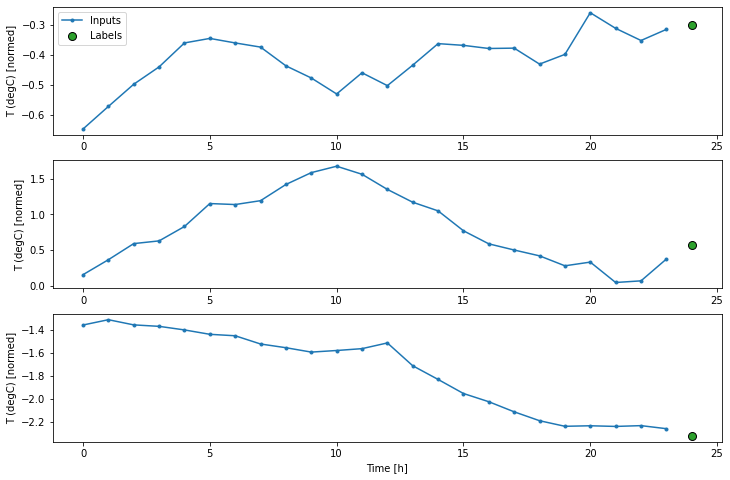

In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=1, shift=1,
    label_columns=['T (degC)'])

wide_window
wide_window.plot()

## Return_sequences

In the tortorial from https://colab.research.google.com/drive/12w6SyrdT5H1LOI7e8jyi2w8tItSeS51G#scrollTo=DXKLCJy8nWNU

it's argued that the performace will be worse for a model using Return_sequences = True, or that it'll give a pessimistic view of the modell performance, becouse "for the first time step, the model has no access to previous steps and, therefore, can't do any better than the simple `linear` and `dense` models." 

Therefor I think using Return_sequences = False might be better in this assignment, also becouse we're only interested in the final output (at t=24), but I still tested the model with both settings:

### Return_sequences = True

In [ ]:
%%time

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM (Return = True)'] = lstm_model.evaluate( wide_window.val)
performance['LSTM (Return = True)'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

438/438 [==============================] - 2s 5ms/step - loss: 0.0730 - mean_absolute_error: 0.2031

CPU times: user 3min 46s, sys: 35.5 s, total: 4min 21s
Wall time: 3min 56s


## Return_sequences = False

In [ ]:
%%time

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM (Return =False)'] = lstm_model.evaluate( wide_window.val)
performance['LSTM (Return =False)'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

438/438 [==============================] - 2s 4ms/step - loss: 0.0056 - mean_absolute_error: 0.0516

CPU times: user 3min 58s, sys: 39.3 s, total: 4min 37s
Wall time: 3min 56s


loss: 0.0056 - mean_absolute_error: 0.0517, which is considerably better than when return_sequence = True.


##1.3 Förbättrad modell
> Hitta en förbättrad LSTM-modell för fallet när man vill prediktera en parameter (temperaturen) ett steg framåt m.h.a de senaste 24 värdena som input. Prova även att använda någon av de de regulariseringsmetoder som finns tillgängliga för RNN och se ifall du på så sätt kan förbättra din modell (detta ska vara regularisering av LSTM lagren, inte t.ex. dropout mellan lagren). Notera att det kan vara svårt att slå baseline för just detta problem och data, men försök. Argumentera för dina val av regularisering och diskutera dina resultat. 


In [ ]:
%%time
lstm_model_L1 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, recurrent_regularizer =tf.keras.regularizers.L1(), return_sequences=False),

    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model_L1, wide_window)

IPython.display.clear_output()
val_performance['LSTM L1'] = lstm_model_L1.evaluate( wide_window.val)
performance['LSTM L1'] = lstm_model_L1.evaluate( wide_window.test, verbose=0)

print()

438/438 [==============================] - 2s 4ms/step - loss: 0.0107 - mean_absolute_error: 0.0549

CPU times: user 3min 30s, sys: 33.9 s, total: 4min 4s
Wall time: 3min 40s


In [ ]:
%%time
lstm_model_L2 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, recurrent_regularizer =tf.keras.regularizers.L2(), return_sequences=False),

    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model_L2, wide_window)

IPython.display.clear_output()
val_performance['LSTM L2'] = lstm_model_L2.evaluate( wide_window.val)
performance['LSTM L2'] = lstm_model_L2.evaluate( wide_window.test, verbose=0)

print()

438/438 [==============================] - 2s 4ms/step - loss: 0.0065 - mean_absolute_error: 0.0573

CPU times: user 2min 50s, sys: 27.1 s, total: 3min 17s
Wall time: 2min 58s


read somewhere that return_sequences=True works better when there is multiple layers, so decided to test that

In [ ]:
%%time
lstm_model_3 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, recurrent_regularizer = tf.keras.regularizers.L2(), return_sequences=True),
    tf.keras.layers.LSTM(32, recurrent_regularizer = tf.keras.regularizers.L2(), return_sequences=True),
    tf.keras.layers.LSTM(32, recurrent_regularizer = tf.keras.regularizers.L2(), return_sequences=True),

    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model_3, wide_window)

IPython.display.clear_output()
val_performance['LSTM 3 layers'] = lstm_model_3.evaluate( wide_window.val)
performance['LSTM 3 layers'] = lstm_model_3.evaluate( wide_window.test, verbose=0)

print()

438/438 [==============================] - 3s 8ms/step - loss: 0.0813 - mean_absolute_error: 0.2178

CPU times: user 3min 39s, sys: 26.1 s, total: 4min 5s
Wall time: 3min 15s


##1.4 GRU-model
>Undersök även prestandan hos en GRU-modell med samma antal noder och lager du använt för din LSTM-modelle du undersökt ovan. Finner du någon skillnad i prestanda, konvergens, tidsåtgång vid träning, eller annat? Diskutera dina resultat och jämför LSTM- och GRU-modellerna.


In [ ]:
%%time
GRU_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.GRU(32, return_sequences=False),

    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(GRU_model, wide_window)

IPython.display.clear_output()
val_performance['GRU'] = GRU_model.evaluate( wide_window.val)
performance['GRU'] = GRU_model.evaluate( wide_window.test, verbose=0)

print()

438/438 [==============================] - 3s 7ms/step - loss: 0.0061 - mean_absolute_error: 0.0540

CPU times: user 2min 58s, sys: 29.2 s, total: 3min 27s
Wall time: 3min 12s


In [ ]:
#return_sequences=True

%%time
GRU_model2 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.GRU(32, return_sequences=True),

    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(GRU_model2, wide_window)

IPython.display.clear_output()
val_performance['GRU (return = True)'] = GRU_model2.evaluate( wide_window.val)
performance['GRU (return =True)'] = GRU_model2.evaluate( wide_window.test, verbose=0)

print()

438/438 [==============================] - 2s 5ms/step - loss: 0.0732 - mean_absolute_error: 0.2041

CPU times: user 2min 17s, sys: 21.5 s, total: 2min 38s
Wall time: 2min 9s


## Diskussion


Comparing the model performance

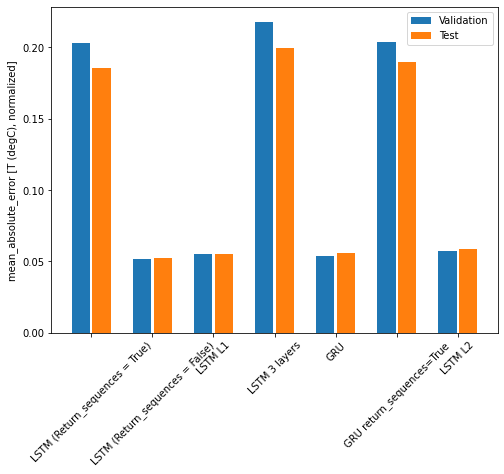

In [ ]:
#code from https://colab.research.google.com/drive/12w6SyrdT5H1LOI7e8jyi2w8tItSeS51G#scrollTo=JjEkt488hi8I
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

LSTM (Return_sequences = True): 0.1857
LSTM (Return_sequences = False): 0.0524
LSTM L1        : 0.0552
LSTM 3 layers  : 0.1996
GRU            : 0.0558
GRU return_sequences=True: 0.1900
LSTM L2        : 0.0588


#### Val av regularizer

Det finns 4 huvudsakliga reguliserings metoder, keras beskriver dem som: 

**kernel_regularizer**: Regularizer function applied to the kernel weights matrix. 

**recurrent_regularizer**: Regularizer function applied to the recurrent_kernel weights matrix. 

**bias_regularizer**: Regularizer function applied to the bias vector. 

**activity_regularizer**: Regularizer function applied to the output of the layer (its "activation").

Jag provade att använda och kombinera dem på lite olika sätt, samt att utöka modellens storlek. Det var dock svårt att se någon tydlig förbättring eller något mönster. 

Jag tyckte att användning av recurrent_regularizer gav bäst resultat. 

När det kommer till själva Regulizerings instälningarna/algorithmer finns det ett gäng att välja på bland annat L1, L2, L1L2 mm där jag inte direkt såg någon större skillnad i resultatet.

#### GRU
**Baseline**
loss: 0.0056 - mean_absolute_error: 0.0517

CPU times: user 4min 7s, sys: 38.8 s, total: 4min 46s
Wall time: 4min 4s

**GRU**
loss: 0.0060 - mean_absolute_error: 0.0543

CPU times: user 3min 34s, sys: 32.6 s, total: 4min 6s
Wall time: 3min 31s

När det kommer till skillnaden i performance mellan GRU och LSTM (baseline modellen) så märktes det inte direkt någon större skillnad. GRU var något snabbare, men i övrigt så var det inte mycket som skillde modellerna.



#Del 2


## upg beskrivning


>Gör två olika modeller som alla ska prediktera vilken temperaturen är 24 timmar fram baserat på de senaste 24 timmarnas mätvärden. D.v.s om din input-sekvens t.ex. löper från timme 1 till och med timme 24, så ska du prediktera vad temperaturen är vid timme 48. Gör detta med dessa tre metoder:

>2.1. Direkt-prediktion av det värdet du söker (single-step with a new target time-step). D.v.s använd 24 timmars input-värden för att endast prediktera ett utvärde. 24 timmar framåt (timme 48). 

>2.2. Gör en prediktion av alla mellanliggande värden också. D.v.s använd återigen 24 timmars input-värden, men prediktera alla värden från timme 25 till och med timme 48. Din output blir nu en 24 värden lång vektor vid varje prediktion (Single shot prediction).


>Notera att vi för dessa två modeller endast är intresserad av kvalitén av prediktionen vid timme 48, så du behöver hitta ett sätt att mäta prestationen för just denna timme för att kunna jämföra modellerna mot modell 2.1 och sinsemellan.

>Jämför prestandan för dina olika modeller sinsemellan, vilka slutsatser drar du? Och, hur väl presterar dessa modeller i jämförelse med fallet i del 1 där vi bara behövde prediktera ett steg framåt?

## 2.1. Direkt-prediktion av det värdet du söker (single-step with a new target time-step). 
D.v.s använd 24 timmars input-värden för att endast prediktera ett utvärde. 24 timmar framåt (timme 48). 


Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

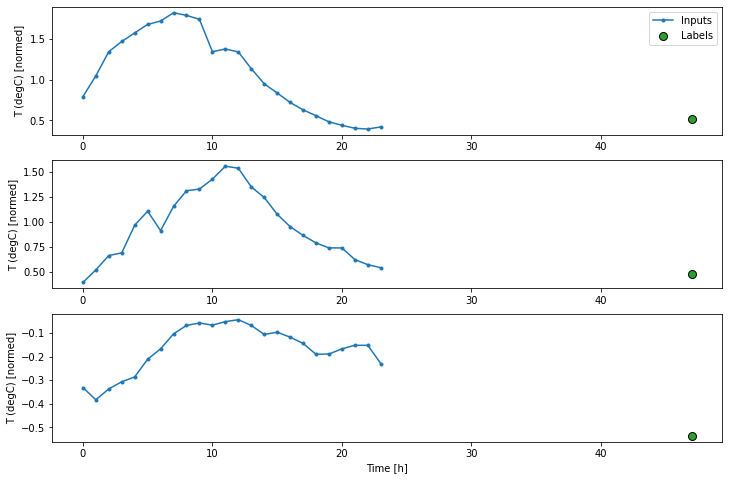

In [ ]:
w2 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w2.plot()
w2

In [ ]:
%%time

lstm_model_w2 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model_w2, w2)

IPython.display.clear_output()
val_performance['LSTM w2'] = lstm_model_w2.evaluate( w2.val)
multi_performance['single-step with a new target time-step'] = lstm_model_w2.evaluate( w2.test, verbose=0)
print()

437/437 [==============================] - 2s 4ms/step - loss: 0.1213 - mean_absolute_error: 0.2726

CPU times: user 1min 6s, sys: 10.7 s, total: 1min 17s
Wall time: 1min 18s


In [ ]:
multi_performance

{'single-step with a new target time-step': [0.094328872859478,
  0.2409048229455948],
 'Single shot prediction': [0.0629035085439682, 0.18905827403068542],
 'Single shot prediction T47': <tf.Tensor: shape=(), dtype=float32, numpy=0.2488742>}

*single-step with a new target time-step* mean absolute error: 0.2726

## 2.2. Gör en prediktion av alla mellanliggande värden (Single shot prediction). 
D.v.s använd återigen 24 timmars input-värden, men prediktera alla värden från timme 25 till och med timme 48. Din output blir nu en 24 värden lång vektor vid varje prediktion (Single shot prediction).

Now the performace is messured on all the labeled timesteps how do we get it for just T = 47?


Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['T (degC)']

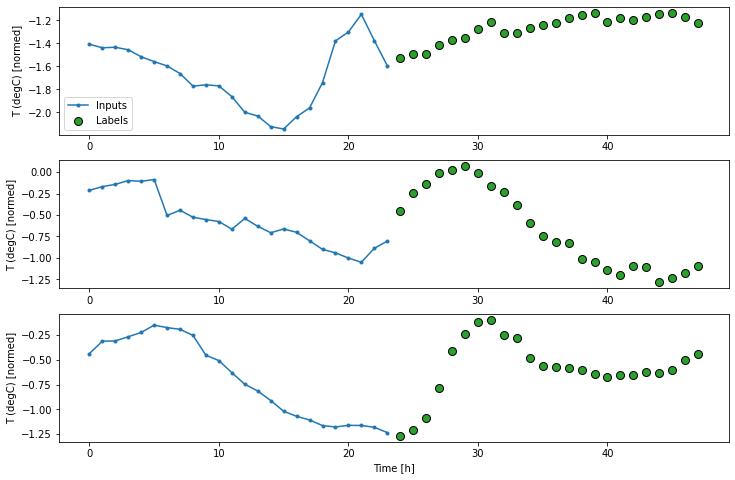

In [ ]:
multi_window = WindowGenerator(input_width=24,
                               label_width=24,
                               shift=24,
                               label_columns=['T (degC)'])

multi_window.plot()
multi_window

437/437 [==============================] - 2s 5ms/step - loss: 0.0772 - mean_absolute_error: 0.2078


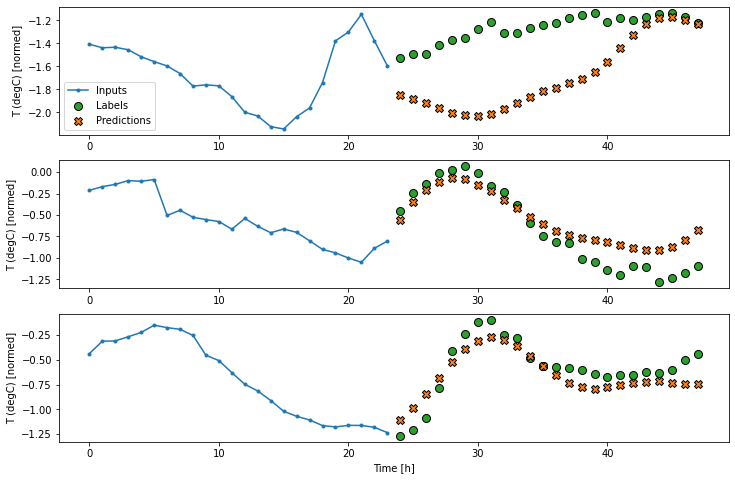

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(24*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([24, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

#evaluate with respect to above window
val_performance['multi LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['Single shot prediction'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### Accuracy at t=47 (den 48e timmen) 
to be able to test the accuracy on only t=47 (den 48e timmen) we need to find a way of messuring it at just that time so first we define X_test and y_test from the test dataset, then we evaluate the accuracy at just T=47

In [ ]:
# Each element is an (inputs, label) pair.
multi_window.test.element_spec

(TensorSpec(shape=(None, 24, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None))

I couldn't find a good way to get X_test and y_test from the data set, so I decided to try this quite unpretty way

1. settign the batch_size (of the make dataset function) large enough so that all the test data fits in one batch (the test dataset has 963 entries (for this data window))
2. get one batch of data (and save it in X_test and y_test)



In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=2000,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
# Create a dataset for the test data
test_dataset = multi_window.test

# Iterate through the test dataset and create X_test and y_test arrays
for x, y in test_dataset:
  X_test = x
  y_test = y
  

In [ ]:
print(X_test.shape)
print(y_test.shape)

(963, 24, 19)
(963, 24, 1)


In [ ]:
# Get the model's predictions on the test set
predictions = multi_lstm_model.predict(X_test)

# Slice the predictions array to only include the T = 47 time step
# T = 47 is nr 23 of the predictions indices,
predictions_T47 = predictions[:, 23, :]

# Slice the y_test array to only include the T = 47 time step
y_test_T47 = y_test[:, 23, :]

# Calculate the mean absolute error between the predictions and ground truth
mae = tf.keras.losses.MeanAbsoluteError()
mae_T47 = mae(y_test_T47, predictions_T47)

# Print the mean absolute error
print(mae_T47)

31/31 [==============================] - 0s 2ms/step
tf.Tensor(0.2488742, shape=(), dtype=float32)


 Single shot prediction, mae = 0.2488742

## Analys
>Notera att vi för dessa två modeller endast är intresserad av kvalitén av prediktionen vid timme 48, så du behöver hitta ett sätt att mäta prestationen för just denna timme för att kunna jämföra modellerna mot modell 2.1 och sinsemellan.

>Jämför prestandan för dina olika modeller sinsemellan, vilka slutsatser drar du? Och, hur väl presterar dessa modeller i jämförelse med fallet i del 1 där vi bara behövde prediktera ett steg framåt?

kollar vi på testsettets *Mean Absolute Error* så får de olika modellerna följande resultat för den 48e timmen. 

**Single-step with a new target time-step:** 0.2409048229455948

**Single shot prediction:** 0.2488742

så resultatet skiljer sig inte jättemycket. Jag tycker att det känns ganska rimligt då modellerna är ganska lika, dem använder samma in-data och även om min *Single shot prediction* model är lite mer komplex (valde att göra den så för att använda samma model som https://colab.research.google.com/drive/12w6SyrdT5H1LOI7e8jyi2w8tItSeS51G#scrollTo=hGjcJsAQJUkI) så är det inte mycket som skilljer dem. Jag hade därför blivit förvånad om det hade skillt mycket mellan modellerna. 

Något jag funderade lite över var att den första modellen (Single-step with a new target time-step) tränas och optimeras för just tidssteget T=47 (timme 48) som vi nu är intereserade av, medans den andra modellen tränas för att optimera för alla de mellanligande tidsstegen också så rent spontant känns det som att modell 1 borde varit bättre på den här uppgiften (vilket, den var, men kanske inte så mycket som jag hade förväntat mig)  

om man gämför med de tidgare modellerna från del 1, så är det tydlig att resultatet för del 2 är betydligt sämre. Baseline/den bästa modelen från del 1 (LSTM) hade en MAE på 0.0524. vilket känns rimligt, då det borde vara en svårare uppgift för systemet att förutse temperaturen längre framåt i tiden. 